In [1]:
from utils.setup import get_model, set_to_eval
from dataset.videoclip_dataset import VideoRead

from dotmap import DotMap
import matplotlib.pyplot as plt
import numpy as np
import torch 
import yaml 
import os 

def imshow(img):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()


def normalize_clip(s):
    """
    s: Predictions: (*, height, width)
    """
    min_ = s.min((1, 2), keepdims=True)
    max_ = s.max((1, 2), keepdims=True)
    return 255 * (s - min_) / (max_ - min_)

# SalViT360 (w/o VAC)

In [2]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

config_fn = 'configs/vst-eval.yml'

config = DotMap(yaml.safe_load(open(config_fn, 'r')))
if config is not None:
    print(config)
model = get_model(config).eval()

set_to_eval(model)

model = model.module.to(DEVICE)

DotMap(Config='VST-LN-T8-Learnable Temporal Emb.', wandb=DotMap(project='OmniAVSAL', name=''), phase=DotMap(name='val'), network=DotMap(backbone='VST', resume='./vst.pt', transformer=DotMap(depth=6, num_heads=8, mlp_dim=4, ff_dropout=0.2, attn_dropout=0.2, multihead=True, new_posemb=True), decoder=DotMap(mode='tangent', norm_layer='layernorm'), use_updated_DST=True, use_amp=False), save='./CkptDir/', train=DotMap(train_bs=16, val_bs=16, use_data_augmentation=True, val_subset=1.0, epoch=DotMap(start=1, n_epochs=5), optim_algorithm='AdamW', sched_algorithm='CosineAnnealingWarmRestarts', optim=DotMap(AdamW=DotMap(lr=1e-05, betas=[0.9, 0.999], weight_decay=0.01), SGD=DotMap(lr=0.0003, nesterov=True, momentum=0.9), Adam=DotMap(lr=0.0003, betas=[0.9, 0.999], weight_decay=0.0), RAdam=DotMap(lr=0.0003, betas=[0.9, 0.999])), sched=DotMap(MultiStepLR=DotMap(milestones=[2, 4, 8], gamma=0.5, verbose=True), ReduceLROnPlateau=DotMap(verbose=True, patience=1, factor=0.1), CosineAnnealingWarmRestarts=

In [3]:
def inference(model, video_path, startingPoint, numSamples, **kwargs):
    video_path = os.path.expanduser(video_path)
    assert os.path.exists(video_path), f"Video path {video_path} does not exist"

    rollingWindow = 8
    
    video = VideoRead(video_path, startingPoint, numSamples + rollingWindow)
    # video = video[0:10]  # Subsample for faster inference
    preds = model.inference(video, **kwargs)
    return video, preds

In [4]:
VIDEO_NAME = '5020.mp4'
VIDEO_ROOT = f'./TestVid/{VIDEO_NAME}'

startingPoint = 600

numSamples = 10

frames, preds = inference(model, VIDEO_ROOT, startingPoint, numSamples)

100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


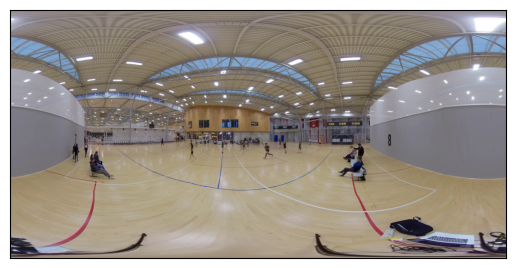

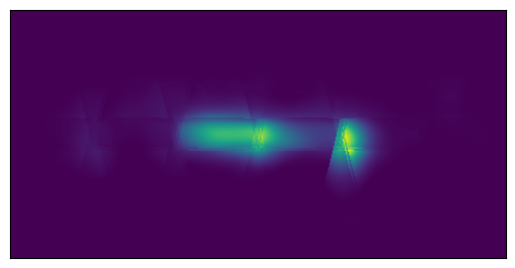

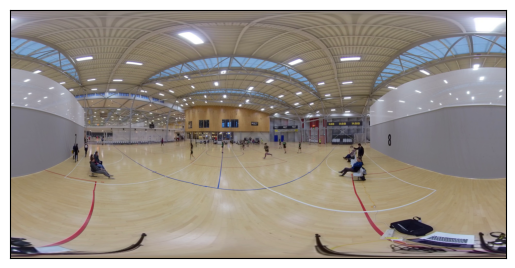

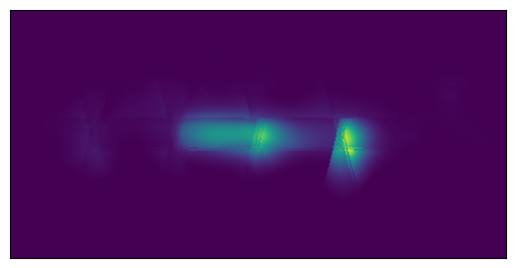

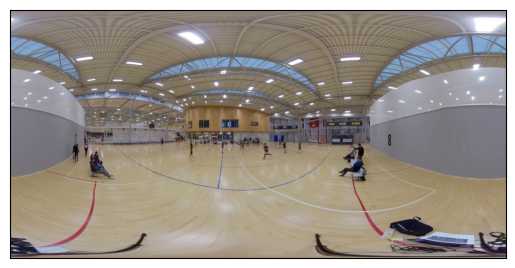

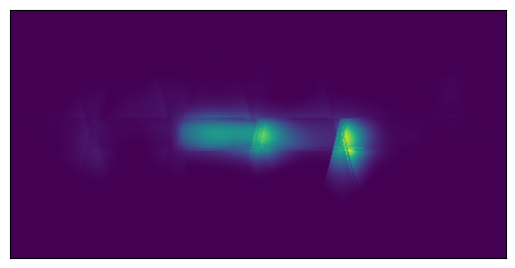

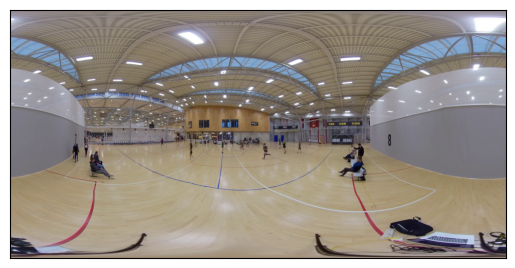

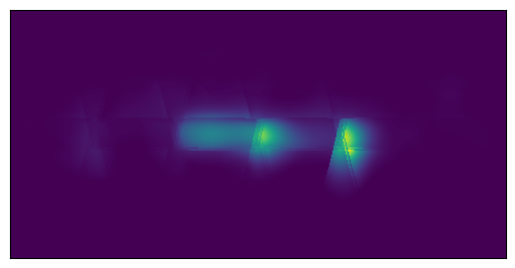

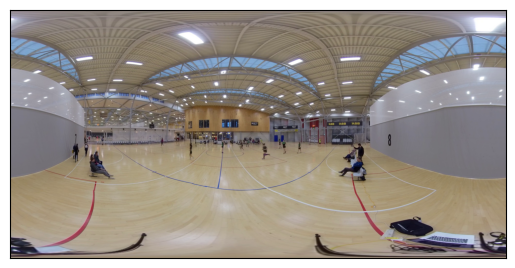

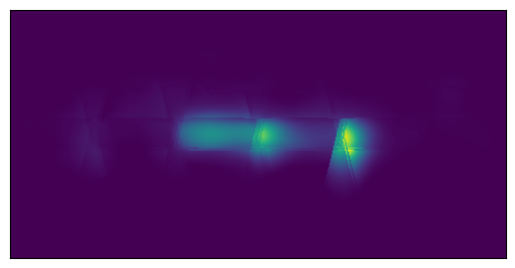

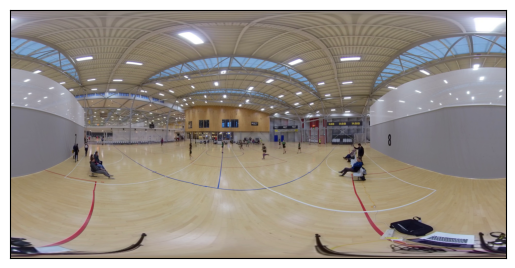

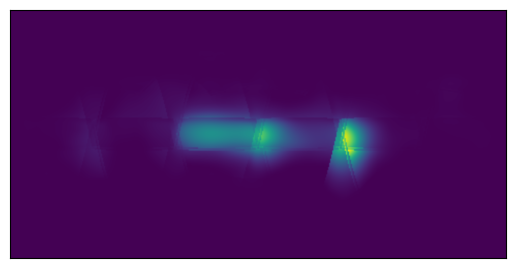

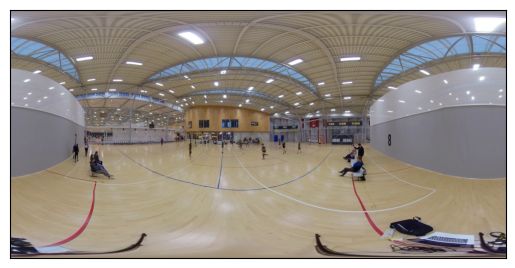

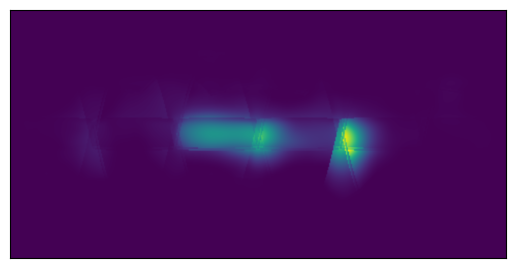

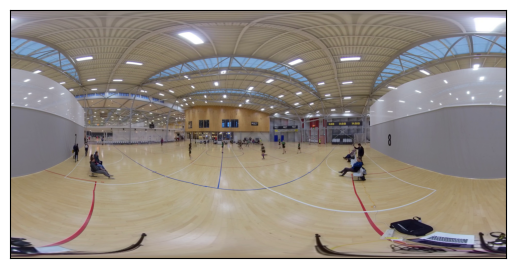

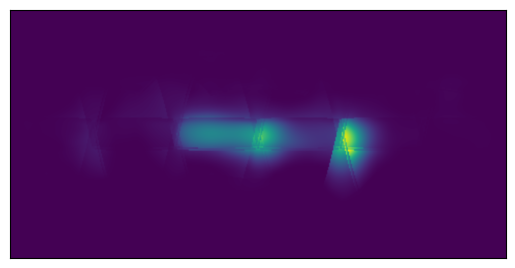

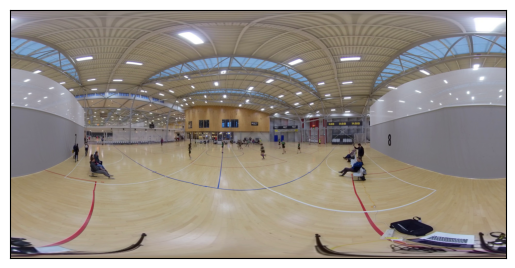

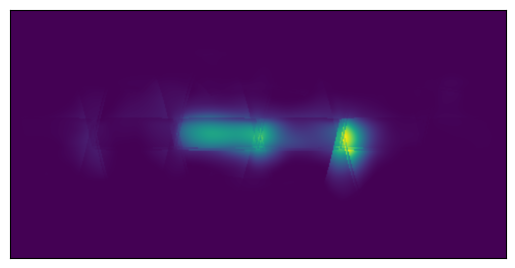

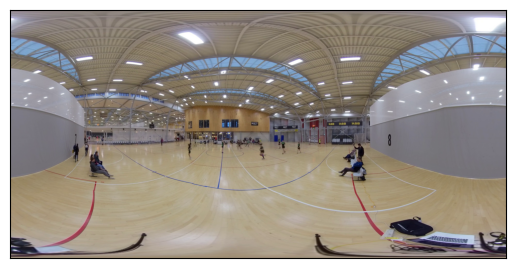

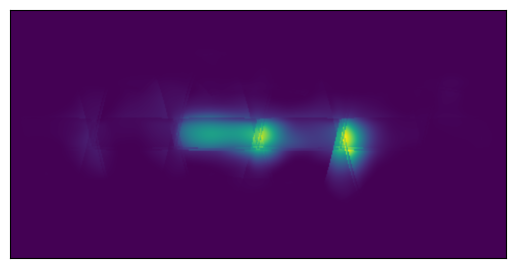

In [5]:
for i in range(numSamples):
    imshow(frames[i])
    imshow(preds[i])